In [1]:
!pip install scikit-fuzzy xgboost seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.1 MB/s eta 0:00:00


FIS (Fuzzy Logic) Metrics: Accuracy: 0.5863453815261044, Precision: 0.5, Recall: 0.006472491909385114, F1: 0.012779552715654952, ROC-AUC: 0.5009531409318615, Inference Time: 0.4124603271484375 seconds
XGBoost (Fuzzy Hybrid) Metrics: Accuracy: 0.8045515394912985, Precision: 0.7620578778135049, Recall: 0.7669902912621359, F1: 0.7645161290322581, ROC-AUC: 0.7990202597863192, Inference Time: 0.08367609977722168 seconds

Model Performance Comparison (Sorted by Accuracy in Descending Order):

                    Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
2             Extra Trees  0.808568   0.782313  0.744337  0.762852  0.799109   
6  XGBoost (Fuzzy Hybrid)  0.804552   0.762058  0.766990  0.764516  0.799020   
3       Gradient Boosting  0.792503   0.763699  0.721683  0.742097  0.782074   
1           Random Forest  0.784471   0.758741  0.702265  0.729412  0.772366   
4                AdaBoost  0.736278   0.680645  0.682848  0.681745  0.728410   
0                     SVM  0

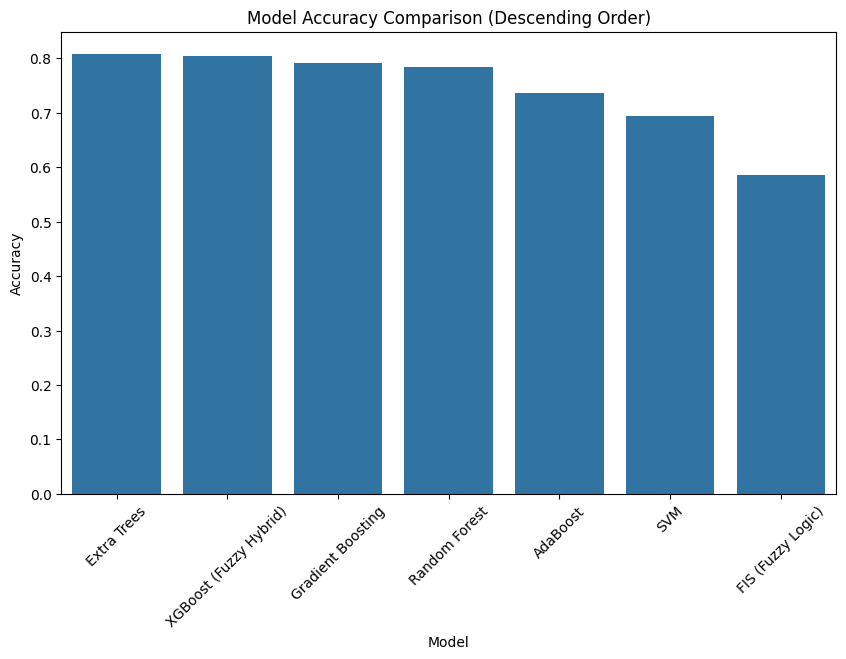

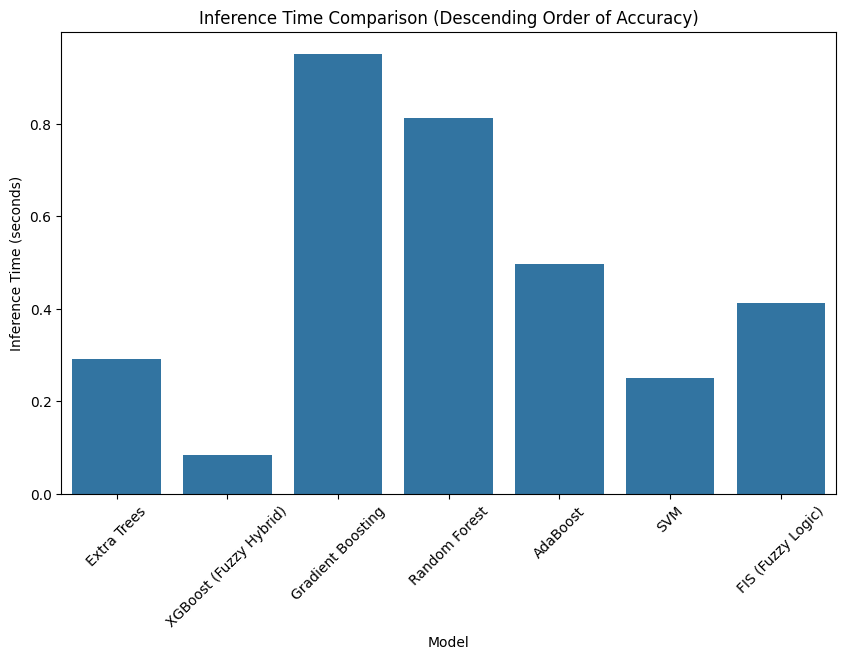

In [13]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import skfuzzy as fuzz
import skfuzzy.control as ctrl
from sklearn.decomposition import PCA
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Step 1: Load the dataset from the CSV file
file_path = '/content/acquiredDataset.csv'
data = pd.read_csv(file_path)

# Step 2: Separate features and target
X = data.drop(columns=['classification'])  # Features
y = data['classification']  # Target

# Step 3: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Reduce dimensionality for fuzzy logic system using PCA (for fuzzy models)
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc, conf_matrix

# Traditional Machine Learning Models
# Step 6: Train and evaluate traditional models

# SVM Model
start_time = time.time()
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_inference_time = time.time() - start_time
svm_metrics = evaluate_model(svm_model, X_test, y_test)

# Random Forest Model
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_inference_time = time.time() - start_time
rf_metrics = evaluate_model(rf_model, X_test, y_test)

# Extra Trees Classifier
start_time = time.time()
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)
et_inference_time = time.time() - start_time
et_metrics = evaluate_model(et_model, X_test, y_test)

# Gradient Boosting Classifier
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_inference_time = time.time() - start_time
gb_metrics = evaluate_model(gb_model, X_test, y_test)

# AdaBoost Classifier
start_time = time.time()
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_model.fit(X_train, y_train)
ab_inference_time = time.time() - start_time
ab_metrics = evaluate_model(ab_model, X_test, y_test)

# Step 7: Fuzzy Logic Approaches
# Custom Fuzzy Inference System (FIS)
def fuzzy_inference_system(X_test_pca):
    # Define fuzzy variables and rules
    input1 = ctrl.Antecedent(np.arange(0, 11, 1), 'input1')
    input2 = ctrl.Antecedent(np.arange(0, 11, 1), 'input2')
    output = ctrl.Consequent(np.arange(0, 11, 1), 'output')

    # Define membership functions: 'low' and 'high'
    input1['low'] = fuzz.trimf(input1.universe, [0, 0, 5])
    input1['high'] = fuzz.trimf(input1.universe, [5, 10, 10])
    input2['low'] = fuzz.trimf(input2.universe, [0, 0, 5])
    input2['high'] = fuzz.trimf(input2.universe, [5, 10, 10])
    output['low'] = fuzz.trimf(output.universe, [0, 0, 5])
    output['high'] = fuzz.trimf(output.universe, [5, 10, 10])

    rule1 = ctrl.Rule(input1['low'] | input2['low'], output['low'])
    rule2 = ctrl.Rule(input1['high'] & input2['high'], output['high'])

    fuzzy_system = ctrl.ControlSystem([rule1, rule2])
    fuzzy_simulation = ctrl.ControlSystemSimulation(fuzzy_system)

    # Make fuzzy predictions on the test set
    fuzzy_predictions = []
    for i in range(len(X_test_pca)):
        fuzzy_simulation.input['input1'] = X_test_pca[i][0]
        fuzzy_simulation.input['input2'] = X_test_pca[i][1]
        fuzzy_simulation.compute()
        fuzzy_predictions.append(fuzzy_simulation.output['output'])

    return np.array(fuzzy_predictions)

# Fuzzy Predictions for FIS
start_time = time.time()
fuzzy_predictions = fuzzy_inference_system(X_test_pca)
fuzzy_inference_time = time.time() - start_time

# Convert fuzzy output to binary class (simplified thresholding)
fuzzy_predictions = fuzzy_predictions > 5  # Threshold based on fuzzy output
fuzzy_accuracy = accuracy_score(y_test, fuzzy_predictions)
fuzzy_precision = precision_score(y_test, fuzzy_predictions)
fuzzy_recall = recall_score(y_test, fuzzy_predictions)
fuzzy_f1 = f1_score(y_test, fuzzy_predictions)
fuzzy_roc_auc = roc_auc_score(y_test, fuzzy_predictions)

# Add this line to calculate the confusion matrix for the FIS model
fuzzy_conf_matrix = confusion_matrix(y_test, fuzzy_predictions)

# Print the results for FIS (Fuzzy Logic)
print(f"FIS (Fuzzy Logic) Metrics: Accuracy: {fuzzy_accuracy}, Precision: {fuzzy_precision}, Recall: {fuzzy_recall}, F1: {fuzzy_f1}, ROC-AUC: {fuzzy_roc_auc}, Inference Time: {fuzzy_inference_time} seconds")

# Step 8: Hybrid Fuzzy-XGBoost Approach with Best Parameters

# Best Parameters from previous grid search
mean_low = 2
sigma_low = 2.0
mean_high = 4
sigma_high = 2.0
learning_rate = 0.2
n_estimators = 100
max_depth = 5
min_child_weight = 1
subsample = 0.8
colsample_bytree = 0.8
gamma = 0.1

# Fuzzification function
def fuzzify_data(X_train, X_test, mean_low, sigma_low, mean_high, sigma_high):
    def gaussian_membership(x, mean, sigma):
        return np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

    X_train_fuzzy = np.zeros(X_train.shape)
    X_test_fuzzy = np.zeros(X_test.shape)

    for i in range(X_train.shape[1]):
        X_train_fuzzy[:, i] = np.maximum(
            gaussian_membership(X_train[:, i], mean_low, sigma_low),
            gaussian_membership(X_train[:, i], mean_high, sigma_high)
        )
        X_test_fuzzy[:, i] = np.maximum(
            gaussian_membership(X_test[:, i], mean_low, sigma_low),
            gaussian_membership(X_test[:, i], mean_high, sigma_high)
        )

    return X_train_fuzzy, X_test_fuzzy

# Fuzzify the data using the best parameters
X_train_fuzzy_best, X_test_fuzzy_best = fuzzify_data(X_train, X_test, mean_low, sigma_low, mean_high, sigma_high)

# Train and evaluate XGBoost with Fuzzified Data
start_time = time.time()
xgb_model = xgb.XGBClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    random_state=42
)
xgb_model.fit(X_train_fuzzy_best, y_train)
xgb_inference_time = time.time() - start_time
xgb_metrics = evaluate_model(xgb_model, X_test_fuzzy_best, y_test)

# Print Fuzzy Hybrid results
print(f"XGBoost (Fuzzy Hybrid) Metrics: Accuracy: {xgb_metrics[0]}, Precision: {xgb_metrics[1]}, Recall: {xgb_metrics[2]}, F1: {xgb_metrics[3]}, ROC-AUC: {xgb_metrics[4]}, Inference Time: {xgb_inference_time} seconds")

# Step 9: Comparison Summary
comparison = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Extra Trees', 'Gradient Boosting', 'AdaBoost', 'FIS (Fuzzy Logic)', 'XGBoost (Fuzzy Hybrid)'],
    'Accuracy': [svm_metrics[0], rf_metrics[0], et_metrics[0], gb_metrics[0], ab_metrics[0], fuzzy_accuracy, xgb_metrics[0]],
    'Precision': [svm_metrics[1], rf_metrics[1], et_metrics[1], gb_metrics[1], ab_metrics[1], fuzzy_precision, xgb_metrics[1]],
    'Recall': [svm_metrics[2], rf_metrics[2], et_metrics[2], gb_metrics[2], ab_metrics[2], fuzzy_recall, xgb_metrics[2]],
    'F1 Score': [svm_metrics[3], rf_metrics[3], et_metrics[3], gb_metrics[3], ab_metrics[3], fuzzy_f1, xgb_metrics[3]],
    'ROC AUC': [svm_metrics[4], rf_metrics[4], et_metrics[4], gb_metrics[4], ab_metrics[4], fuzzy_roc_auc, xgb_metrics[4]],
    'Inference Time (seconds)': [svm_inference_time, rf_inference_time, et_inference_time, gb_inference_time, ab_inference_time, fuzzy_inference_time, xgb_inference_time]
})

# Sort the results by accuracy in descending order
comparison_sorted = comparison.sort_values(by='Accuracy', ascending=False)

# Print the sorted table
print("\nModel Performance Comparison (Sorted by Accuracy in Descending Order):\n")
print(comparison_sorted)

# Visualization: Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_sorted)
plt.title('Model Accuracy Comparison (Descending Order)')
plt.xticks(rotation=45)
plt.show()

# Visualization: Inference Time
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Inference Time (seconds)', data=comparison_sorted)
plt.title('Inference Time Comparison (Descending Order of Accuracy)')
plt.xticks(rotation=45)
plt.show()